In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE_H = 405
IMAGE_SIZE_W = 720
CHANNELS = 3
EPOCHS = 5

In [5]:
# Function to display original and adversarial images
def display_images(original_images, adversarial_images, original_labels, adversarial_labels):
    num_images = min(5, len(original_images))
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_images[i].numpy().astype("uint8"))
        plt.title(f"Original: {class_names[original_labels[i]]}")
        plt.axis("off")
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(adversarial_images[i].numpy().astype("uint8"))
        plt.title(f"Adversarial: {class_names[adversarial_labels[i]]}")
        plt.axis("off")
    plt.show()

In [6]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "H-pylori",
    shuffle=True,
    image_size=(IMAGE_SIZE_H, IMAGE_SIZE_W),
    batch_size=BATCH_SIZE
)

Found 4629 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names

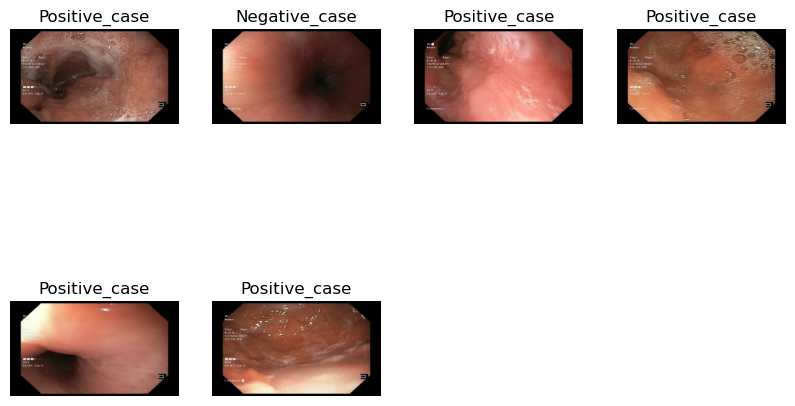

In [8]:
# visualizing some images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
# Function to partition dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
# Cache, shuffle, and prefetch datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
#This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#somone can supply an image that is not (256,256) and this layer will resize it

# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE_H, IMAGE_SIZE_W),
  tf.keras.layers.Rescaling(1./255),
])


In [13]:
#boost the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
# Model definition
input_shape = (BATCH_SIZE, IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 405, 720, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 403, 718, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 403, 718, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 201, 359, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 199, 357, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 199, 357, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 178, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 97, 176, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 97, 176, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 88, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 540672)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      69,206,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,300,546 (264.36 MB)

 Trainable params: 69,300,098 (264.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
# PGD attack function
def pgd_attack(model, images, labels):
#     epsilon = 0.1
#     alpha = 0.001
#     epsilon = 0.3
#     alpha = 0.03

    epsilon = 0.4
    alpha = 0.04
    iterations = 20
    return projected_gradient_descent(model, images, eps=epsilon, eps_iter=alpha, nb_iter=iterations, norm=np.inf, clip_min=0, clip_max=1, y=labels)


In [40]:
class PGDAttackCallback(tf.keras.callbacks.Callback):
    def __init__(self, pgd_attack):
        super(PGDAttackCallback, self).__init__()
        self.pgd_attack = pgd_attack
        self.train_batch = None

    def on_train_batch_end(self, batch, logs=None):
        if self.train_batch is None:
            return  # Skip if train_batch is not set
        adv_images = self.pgd_attack(self.model, self.train_batch[0], self.train_batch[1])
        self.train_batch = (tf.concat([self.train_batch[0], adv_images]), 
                            self.train_batch[1])


In [41]:
# Define callback to save checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model.keras',
    save_weights_only=False,  # Save entire model
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

In [42]:
# Callback from checkpoints
latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
if latest_checkpoint:
    print("Loading weights from", latest_checkpoint)
    model.load_model(latest_checkpoint)


In [43]:
# Evaluate model on validation set before training
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy (Before Training): {val_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8118 - loss: 0.5154
Validation Accuracy (Before Training): 0.8169642686843872


In [44]:
# Training with model.fit and callbacks
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[PGDAttackCallback(pgd_attack)]
)

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1737s 15s/step - accuracy: 0.8071 - loss: 0.5192 - val_accuracy: 0.8125 - val_loss: 0.5044
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1708s 15s/step - accuracy: 0.7986 - loss: 0.5157 - val_accuracy: 0.8125 - val_loss: 0.4973
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1733s 15s/step - accuracy: 0.8041 - loss: 0.5040 - val_accuracy: 0.8125 - val_loss: 0.4924
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 2392s 21s/step - accuracy: 0.7979 - loss: 0.5077 - val_accuracy: 0.8125 - val_loss: 0.4893
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1709s 15s/step - accuracy: 0.8006 - loss: 0.5022 - val_accuracy: 0.8125 - val_loss: 0.4872


In [45]:
# Evaluate model on validation set after training
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy (After Training): {val_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8126 - loss: 0.4872
Validation Accuracy (After Training): 0.8125


In [46]:
# Evaluate model on test set after training
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8147 - loss: 0.4832
Test Accuracy: 0.8229166865348816


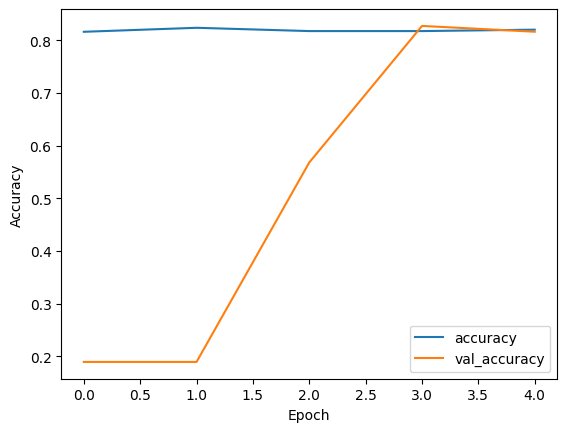

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

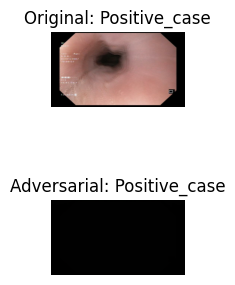

In [36]:
# Display one original and one adversarial image
for batch_images, batch_labels in test_ds.take(1):
    adv_images = pgd_attack(model, batch_images, batch_labels)
    display_images(batch_images[:1], adv_images[:1], batch_labels[:1], batch_labels[:1])

In [37]:
# Save the model
model.save("model_with_adversarial_training.h5")

In [1]:
#some methods except for pgd and fsgm (fahad is doing these) are:
#1. TRADES (TRadeoff-inspired Adversarial DEfense via Surrogate-loss minimization)
#2. Mixup

#will try doing TRADES once hyperparameter tuning is done for pgd (changing alpha values)
#in the meantime fahad will be doing fgsm 

#3 are enuff methods then we'll start importing the model and creating front-end with test images